In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import signal
from scipy.stats import norm
from scipy.ndimage import gaussian_filter
import math

##### Mittelwert / Mean

In [58]:
# meam = x_bar = sum(x)/n
def Mean(x):
    return np.mean(x)
    
# Mittelwert (Mean) = Erwartungswert = mu für grosse N
def Mittelwert(x):
    #return np.sum(x)/len(x)
    return Mean(x)

##### Standardabweichung sigma, Varianz var(x) = sigma^2

In [28]:
# Standardabweichung / Standard_deviation / sigma
# Die STD gibt das gewicht der pdf um den Erwartungswert an,
# dh mit welcher Wahrscheinlichkeit ein Messergebnis im Bereich [mu - n*sigma, mu + n*sigma] ist
def STD(x):
    return np.std(x)

def Var(x):
    return STD(x)**2

##### Dynamic Range DR

In [11]:
# Dynamic Range DR
# x_min: Signalauflösung (=min_step)
# x_max: Grenze der Linearität / des Modells
def DynamicRange(x_min, x_max):
    return 20*np.log10(x_max / x_min)

# Beispiel:
## Da der Spannungsbereich von -1V bis +1V geht, wird insgesamt über 2V gemessen -> x_max = 2.
## 2V / 2^bits = minimale Schrittgrösse
x_max_beispiel = 2
def min_step(x):
    steps = np.zeros(len(x)-1) # initialisiere ein Array mit 0en um die Differenzen darin zu speichern
    for i in range(len(steps)):
        steps[i] = abs(x[i+1]-x[i]) #Differenzen
    min_step = np.min(steps[np.nonzero(steps)]) # Minimalen Schritt finden (ohne 0)
    print('minimale Schrittgrösse:', min_step)
    return min_step
#  dynamic_range = 20*np.log10(x_max/min_step)

# Dynamic Range DR
# p_min, p_max: Leistungswerte
def DynamicRange_byPower(p_min, p_max):
    return 10*np.log10(p_max / p_min)

##### adc_bittiefe

In [ ]:
def adc_bittiefe(x_max, min_step):
    return np.log2(x_max/min_step)

#### Messzeit, zeitliche Auflösung dT, Messrate, spektrale Auflösung

In [13]:
# Messzeit T = Dauer des Messvorgangs
# Zeitliche Auflösung dT = kleinstes Messbares Zeitintervall

# Messrate = 1/dT
# dt: Zeitliche Auflösung
def Messrate(dt):
    return 1/dt

# Spektrale Auflösung = 1/T
# T: Messzeit
def SpektraleAufloesung(T):
    return 1/T

# Messbandbreite = 1/(2dt)
# dt: Zeitliche Auflösung
def Messbandbreite(dt):
    return 1/(2*dt)

In [76]:
def StandardErrorOfTheMean(sample_x):
    return np.std(sample_x)/len(sample_x)

# Fehler des Mittelwerts sigma_xbar
# x: N data points
# n_bins: Anzahl bins um die einzelnen Mittelwerte auszurechnen
# Der Fehler des Mittelwertes geht mit 1/sqrt(N=sample size) wie in der Vorlesung hergeleitet.
# TODO
def ErrorOfTheMean(x, n_bins):
    bins = np.array_split(x, n_bins)
    means = np.zeros(n_bins)
    for i in range(0, len(means)):
        means[i] = np.mean(bins[i])
    return np.std(means)

def ErrorOfTheMean_FrontToBack(x):
    bins = [x[3:3+i] for i in range(1, len(x)+1-3)]
    means = np.zeros(len(bins))
    for i in range(0, len(means)):
        means[i] = np.mean(bins[i])
    return np.std(means)

def ErrorOfTheMean_ByMeans(means):
    return np.std(means)

def Fehler_Des_Mittelwerts(x):
    return ErrorOfTheMean(x, int((len(x)/10)+1))

(0.3486198538080352, 0.18500671850814904, 0.015339758815582919)

#### Root Mean Square / Root Mean Square Error / Mean Square Error / Messfehler / Error

In [14]:
# Root Mean Square
# x: Liste von Messwerten
def RMS(x):
    return np.sqrt(
        np.sum(x**2) / len(x)
    )

# Mean Square Error
def MSE(actual_values, predicted_values):
    diff = np.subtract(actual_values, predicted_values)
    squared_error = np.square(diff)
    mse = squared_error.mean()
    return mse

# Root Mean Square Error
def RMSE(actual_values, predicted_values):
    mse = MSE(actual_values, predicted_values)
    rmse = math.sqrt(mse)
    return rmse

def Messfehler(wert, erwartungswert):
    return erwartungswert - wert

def Error(x, x_expected):
    return np.subtract(x_expected, x)

#### Signal to Noise Ratio
Das Singal-to-Noise Ratio ist ein Mass für das Verhältnis zwischen Signal und Rauschen in einer
Messung. Ist das Ratio gleich oder kleiner als 1, so ist die Qualität des Signals schlecht. Die üblichste
Definition ist mittels der Leistung des Signals (psignal) bzw. des Rauschens (pnoise):
- SNR = p_signal / p_noise
- SNR = (A_signal / A_noise)^2 mit A = sqrt(1/n * (x_1^2 + ... + x_n^2) )
- SNR = 2H / h mit H = Durchmesser des peaks, h = Durchmesser des Noise

In [3]:
# p_signal: Leistung des Signals
# p_noise: Leistung des Rauschens
def SNR(p_signal, p_noise):
    return p_signal / p_noise

# A_rms_signal: Root mean square der Signalmesswerte
# A_rms_noise: Root mean square der Noisewerte
def SNR_by_rms(A_rms_signal, A_rms_noise):
    return (A_rms_signal / A_rms_noise)**2

# x_signal: Liste von Werten im Signalbereich
# x_noise: Liste von Werten im Noisebereich
def SNR_mit_distkreter_reihe_von_messwerten(x_signal, x_noise):
    return SNR_by_rms(RMS(x_signal), RMS(x_noise))


##### Normalverteilung, PDF
PDF = Probability Density Function der Normalverteilung: 1σ → 68 %, 2σ → 95 %, 3σ → 99.7 %, · · ·, 5σ → 99.99994 

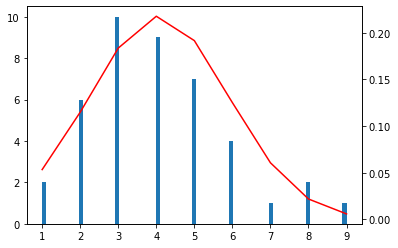

In [98]:
# Wahrscheinlichkeitsdichtefunktion der Normalverteilung
# mu: Erwartungswert
# sigma: Standardabweichung
# def PDF_by_me_wrong(x, mu, sigma):
#    q = -((x-mu)**2)/(2*(sigma**2))
#    return (1/sigma*math.sqrt(2*np.pi))*np.exp(q)

# Wahrscheinlichkeitsdichtefunktion der Normalverteilung
def PDF(x):
    _MEAN=np.mean(x)
    _STD=np.std(x)
    return norm.pdf(x, loc=_MEAN, scale=_STD)

def plot_sample_1():
    # Beispiel Plot mit histogramm und pdf
    xxxxx=[1,2,3,4,5,6,2,3,4,4,3,4,3,2,5,3,3,2,1,3,4,5,6,6,5,4,3,2,2,3,4,5,9,8,3,4,5,6,4,7,8,5]
    xxxxx.sort()
    __pdf = PDF(xxxxx)
    fig, ax = plt.subplots()
    ax.hist(x=xxxxx, bins=75)
    ax2 = ax.twinx()
    ax2.plot(xxxxx, __pdf, color='red')
    plt.show()
#plot_sample_1()

In [87]:
# Random Values gauss distribution
import random
import scipy.integrate

__mu = 100 # expected value 
__sigma = 50 # standard deviation

# Generate Random values with gauss distribution
print(random.gauss(__mu, __sigma))
print(np.random.normal(__mu, __sigma, 10000)) # mean, std, length

def gaussian_pdf(x, mu, sigma):
    return norm.pdf(x, loc=mu, scale=sigma)

# Area Under Curve of PDF = Probability Density Function (Gaussian / Normalverteilung)
# The total area is the probability for something to be in [mu-n*sigma, mu+n*sigma]
def AreaUnderNormalPDF(mu, sigma, NumStd):
    area = scipy.integrate.quad(
        gaussian_pdf,
        mu - NumStd*sigma,
        mu + NumStd*sigma,
        (mu,sigma))[0]
    return area

# 1sigma ==> 68%
AreaUnderNormalPDF(0, 1, 1)


105.98020095172552


0.682689492137086

##### Probability Mass Function PMF, Mode, Median, Halbwertsbreite FWHM

In [ ]:
# PMF berechnen aus einem beliebigen array
def PMF(data_array, bin_nr):
    y, bin_edges = np.histogram(data_array, bin_nr)
    # Here we compute an array with bin centers based on bin_edges positions
    x = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(bin_nr)]
    # We normalize y with its sum
    yn = y / np.sum(y)
    return x, yn

# Here is an equivalent implementation that does not use np.histogram function (does not need to implemented by the students)
def PMF_direct(data_array, bin_nr):
    # Here we define the positions of bin edges (for bin_nr bins there will be bin_nr + 1 edges)
    bin_edges = np.linspace(min(data_array), max(data_array), bin_nr + 1)
    # Here we define the array with bin centers
    x = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(bin_nr)]
    # Here we prepare the array in which we will store a histogram (initially filled with zeros)
    y = np.zeros(bin_nr)
    # For every data point we check to which bin it falls
    for data_value in data_array:
        for i in range(bin_nr):
            if data_value >= bin_edges[i] and data_value < bin_edges[i + 1]:
                y[i] += 1
    # Finally, we normalize y with its sum
    return x, y / np.sum(y)

def get_bin_nr(factor, arr_len):
    return int(round(factor*np.sqrt(arr_len)))

# x_mode
# Call this function like:
#  x, pmf = PMF(data_array, bin_nr)
#  x_mode = mode(x, pmf)
def mode(x, PMF):
    return x[np.argmax(PMF)]

# x_median
def median(x, PMF):
    sub_sums = [np.sum(PMF[:i]) for i in range(1, len(PMF) + 1)]
    return x[np.searchsorted(sub_sums, 1/2)]

def FWHM_numerically(x, PMF):
    # Variable that stores the mode position
    mode_position = mode(x, PMF)
    # Shift the PMF values by half of their maximal value
    PMF_shifted = PMF - np.max(PMF) / 2
    # Prepare empty arrays that will store the crossing positions in the rising and falling slope.
    crossings_low = []
    crossings_high = []
    for i in range(len(PMF) - 1):
        # Search for the crossing
        if (PMF_shifted[i] * PMF_shifted[i + 1] <= 0) and not ((PMF_shifted[i] == 0) and (PMF_shifted[i + 1] == 0)):
            # Interpolate between x[i] and x[i+1] values.
            if (PMF_shifted[i] <= PMF_shifted[i + 1]):
                crossing_position = np.interp(0, [PMF_shifted[i],PMF_shifted[i + 1]], [x[i],x[i+1]])
            else:
                crossing_position = np.interp(0, [PMF_shifted[i+1],PMF_shifted[i]], [x[i+1],x[i]])   
            # Check if the current crossing is on the left of right side of the mode
            if (crossing_position > mode_position):
                crossings_high.append(crossing_position)
            else:
                crossings_low.append(crossing_position)        
    # Determine the average position of the crossings occuring in the rising and falling slope, as well as their difference.
    return np.average(crossings_low), np.average(crossings_high), np.average(crossings_high) - np.average(crossings_low)

def FWHM_bySigma(data_array):
    return 2*np.sqrt(2*np.log(2))*np.std(data_array)

def example_pmf_mode_median_fwhm_plot(data_array):
    bin_nr = get_bin_nr(0.8, len(data_array))
    x, y = PMF(data_array, bin_nr) # x=x, y=PMF

    # Plot the histogram with regular line plot
    fig, ax = plt.subplots()
    ax.plot(x,y)
    ax.set_xlabel('Data value')
    ax.set_ylabel('PMF')
    plt.show()

    # Plot the histogram with bar plot
    fig, ax = plt.subplots()
    ax.bar(x, y, width = x[1] - x[0])
    ax.set_xlabel('Data value')
    ax.set_ylabel('PMF')
    plt.show()

    # Mode, Median, Mean
    print("Mode of the PMF =", mode(x,y), "; median of the PMF =", median(x,y), "; mean of the PMF", np.mean(data_array))

    # Plot the histogram together with vertical lines indicating the mode, median and mean.
    fig, ax = plt.subplots()
    ax.bar(x,y,width=(x[1] - x[0]))
    ax.axvline(np.mean(data_array), color='g', label = "mean = {0}".format(np.round(np.mean(data_array), 4)))
    ax.axvline(mode(x,y), color='r', label = "mode = {0}".format(np.round(mode(x,y), 4)))
    ax.axvline(median(x,y), color='black', label = "median = {0}".format(np.round(median(x,y), 4)))
    plt.legend(loc="upper right")
    ax.set_xlabel('Data value')
    ax.set_ylabel('PMF')
    plt.show()

    # Determine FWHM and print it
    low, high, FWHM_value = FWHM_numerically(x,y)
    print("FWHM of the PMF =", FWHM_value, "; 2*sqrt(2*ln(2))*sigma =", FWHM_bySigma(data_array))

    # Plot the data together with the line segment indicating the FWHM
    fig, ax = plt.subplots()
    ax.bar(x,y,width=(x[1] - x[0]))
    ax.axvline(np.mean(data_array), color='g', label = "mean = {0}".format(np.round(np.mean(data_array), 4)))
    ax.axvline(mode(x, y), color='r', label = "mode = {0}".format(np.round(mode(x,y), 4)))
    ax.axvline(median(x, y), color='black', label = "median = {0}".format(np.round(median(x,y), 4)))
    ax.hlines(0.5 * np.max(y), xmin = low, xmax = high, color = 'purple', label = "FWHM = {0}".format(np.round(FWHM_value,4)))
    ax.set_xlabel('Data value')
    ax.set_ylabel('PMF')
    plt.legend(loc="upper left")
    plt.show()

##### M-tes Moment einer PMF
Die Varianz=sigma^2 ist gegeben durch M_2 - M_1^2
Der Mittelwert ist das Erste Moment: Mean = M_1

In [ ]:
# Berechne das M-te Moment der PMF
def moment(x, PMF, m):
    return np.sum([PMF[i] * x[i] ** m for i in range(len(x))])

def compute_Var_by_Moments(x, PMF):
    return moment(x,PMF,2) - moment(x,PMF,1)**2

def compute_STD_by_Moments(x, PMF):
    return np.sqrt(compute_Var_by_Moments(x, PMF))

def compute_Mean_by_Moments(x, PMF):
    return moment(x,PMF,1)

def example_moments(data_array):
    # Compute the PMF
    x, y = PMF(data_array, get_bin_nr(4, len(data_array)))
    #x, y = PMF(data_array**2, bin_nr)
    # Print the moments as well as the ratio between Mi and M1^i.
    print("0th moment =", moment(x,y,0))
    print("1st moment =", moment(x,y,1))
    print("2nd moment =", moment(x,y,2), "; ratio M2/M1^2 =", moment(x,y,2) / moment(x,y,1)**2)
    print("3rd moment =", moment(x,y,3), "; ratio M3/M1^3 =", moment(x,y,3) / moment(x,y,1)**3)
    print("4th moment =", moment(x,y,4), "; ratio M4/M1^3 =", moment(x,y,4) / moment(x,y,1)**4)
    # The ratios of Mm/M1^m are close to 1 for symmetric gaussian-like noise.
    # For more asymmetric PMF (obtained for 2nd or 3rd power of data),
    # the ratios sizably deviate from 1, particularly for higher moments.

    # Compute standard deviation based on 1st and 2nd moments
    print("Sigma based on 1st and 2nd moments =", compute_STD_by_Moments(x,y),"; direct sigma =", np.std(data_array))

##### Sampling Frequency (Abtastrate) | f_S

In [ ]:
# Sampling Frequency / Abtastrate f_s
# t0: Messzeit (T)
def SamplingFrequency(t0):
    return 1/t0

## Shannon-Nyquist Theorem:
# Die Sampling Frequenz / Abtastrate muss mindestens 2x so hoch sein wie die Erwünschte/Maximale zu messende Frequenz des Signals
# f_s = Sampling Rate
def ShannonNyquist_MaxMeasurableFrequency(f_s):
    return 1/(2*f_s)

def ShannonNyquist_MinSamplingRateToMeasureFrequency(freq_max):
    return 2*freq_max

##### Binomialverteilung
Die Binomialverteilung gibt die Wahrscheinlichkeit an, dass für einen Zustand Ψ mit n Variablen, k von denen einen Wert u annehmen.
- mu = M1 = n*p
- sigma = sqrt(n)
- var = sigma**2 = M2 - M1^2 = npq

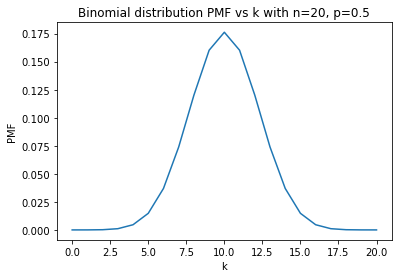

In [175]:
def binomialkoeff(n, k):
    return 1 if k == 0 or k == n else np.prod([(n + 1 - i) / i for i in range(1, k + 1)])

# Wahrscheinlichkeit, dass für einen Zustand mit n Variablen
# k von denen einen Wert u annehmen
# p = P(u)
# q = 1-p = wahrscheinlichkeit für nicht u
def P_Binomialverteilung(k, n, p):
    q = 1 - p
    return binomialkoeff(n, k) * p**k * q**(n-k)

def PMF_binomial_distribution(ks,n,p):
    return scipy.stats.binom.pmf(ks,n,p)

def example_binomial_distribution_plots():
    n = 20
    p = 0.5
    ks = np.arange(0,21)
    binomial_pmf = PMF_binomial_distribution(ks,n,p)
    # Plot the histogram with regular line plot
    fig, ax = plt.subplots()
    ax.plot(ks,binomial_pmf)
    ax.set_xlabel('k')
    ax.set_ylabel('PMF')
    plt.title('Binomial distribution PMF vs k with n=20, p=0.5')
    plt.show()
example_binomial_distribution_plots()

# Erstes Moment der Binomialverteilung
# entspricht dem Mittelwert der Binomialverteilung
def Binomialverteilung_M1(n, p):
    return n*p

def Binomialverteilung_M2(n, p):
    q = 1 - p
    return n**2 * p**2 + n*p*q

def Binomialverteilung_Mean(n, p):
    return Binomialverteilung_M1(n,p)

def Binomialverteilung_STD(n):
    return np.sqrt(n)

def AreaUnderBinomialPMF(n, p, k_min, k_max):
    ks = np.arange(k_min, k_max+1)
    binomial_pmf = PMF_binomial_distribution(ks, n, p)
    return sum(binomial_pmf)
    

##### Poisson-Verteilung
Die Poisson-Verteilung ist ein Grenzfall der Binomialverteilung für sehr seltene Ereignisse.
- Die Anzahl der Messungen n ist sehr gross.
- Die Anzahl der Ereignisse pro Messung k ist klein, d.h. n ≫ k
- Die Wahrscheinlichkeit für ein Event p ist sehr klein (p → 0)
- mu = M1
- var = mu
- sig = sqrt(mu)

C:\Users\domin\AppData\Local\Temp/ipykernel_6152/3485963537.py:10: DeprecationWarning: Using factorial() with floats is deprecated
  return [mu**k * np.exp(-mu) / math.factorial(k) for k in k_arr]
C:\Users\domin\AppData\Local\Temp/ipykernel_6152/3485963537.py:10: DeprecationWarning: Using factorial() with floats is deprecated
  return [mu**k * np.exp(-mu) / math.factorial(k) for k in k_arr]
C:\Users\domin\AppData\Local\Temp/ipykernel_6152/3485963537.py:10: DeprecationWarning: Using factorial() with floats is deprecated
  return [mu**k * np.exp(-mu) / math.factorial(k) for k in k_arr]
C:\Users\domin\AppData\Local\Temp/ipykernel_6152/3485963537.py:10: DeprecationWarning: Using factorial() with floats is deprecated
  return [mu**k * np.exp(-mu) / math.factorial(k) for k in k_arr]
C:\Users\domin\AppData\Local\Temp/ipykernel_6152/3485963537.py:10: DeprecationWarning: Using factorial() with floats is deprecated
  return [mu**k * np.exp(-mu) / math.factorial(k) for k in k_arr]
C:\Users\domin\

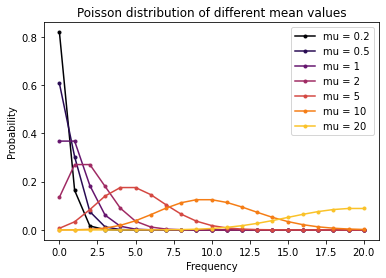

In [178]:
# P(k) wahrscheinlichkeit k Ereignisse in einer Messung zu finden (sehr klein)
def P_poisson(k, mu):
    return mu**k * np.exp(-mu) / math.factorial(k)

# PMF der Poisson-Verteilung
# k_arr: Liste von Werten für k (Anz Ereignisse), e.g. np.linspace(0/*first*/, 99/*last/*, 100/*num*/)
# mu = mean der Binomialverteilung = n*p, wobei p = wahrsch. für ein Event
# gibt die PMF der wahrscheinlichkeiten für alle diese k's zurück
def PMF_poisson_distribution(k_arr, mu):
    return [mu**k * np.exp(-mu) / math.factorial(k) for k in k_arr]

def plot_poisson_distribution_pmf(ks, mu):
    # Plot the data
    fig, ax = plt.subplots()
    # plot graphs for different mu values
    ax.plot(ks,PMF_poisson_distribution(ks,mu), color = 'blue', marker='o', markersize = '3', label = "mu = {0}".format(mu))
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Probability')
    plt.legend(loc="upper right")
    plt.show()

def example_poisson_distribution_plots():
    # Prepare arrays storingng frequencies and mus
    ks = np.linspace(0, 20, 21)#[0,1,2,...,20]
    mus = [0.2, 0.5, 1, 2, 5, 10, 20]
    # Prepare an array that will store colors for each curve (this can be done also manually)
    from matplotlib import cm
    cmap = cm.get_cmap('inferno')
    colors = cmap([np.arange(0, 1, 1 / len(mus))])[0]
    # Plot the data
    fig, ax = plt.subplots()
    # plot graphs for different mu values
    for i, mu in enumerate(mus):
        ax.plot(ks,PMF_poisson_distribution(ks,mu), color = colors[i], marker='o', markersize = '3', label = "mu = {0}".format(mu))
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Probability')
    plt.legend(loc="upper right")
    plt.title('Poisson distribution of different mean values')
    plt.show()
example_poisson_distribution_plots()

def Poissonverteilung_Mean_by_pmf(k_arr, pmf):
    #pmf = PMF_poisson_distribution(k_arr, mu)
    return compute_Mean_by_Moments(k_arr, pmf)

def Poissonverteilung_Var(mean):
    return mean

def Poissonverteilung_Std(mean):
    return np.sqrt(mean)

# Area Under Curve of PDF = Probability Density Function (Gaussian / Normalverteilung)
# The total area is the probability for something to be in [mu-n*sigma, mu+n*sigma]
def AreaUnderPoissonPMF(mu, k_min, k_max):
    ks = np.linspace(k_min, k_max, k_max - k_min + 1)
    pmf = PMF_poisson_distribution(ks, mu)
    plot_poisson_distribution_pmf(ks, mu)
    return sum(pmf)
#AreaUnderPoissonPMF(3, 1, 5)

##### Kovarianz, Korrelations-Koeffizient, Auto-Kovarianz
- Exercise Woche 6

In [123]:
# x, y: Equally long arrays of values
def covariance(x, y):
    N = len(x)
    x_mean, y_mean = Mean(x), Mean(y)
    cov = 0.0
    for i in range(0, N):
        cov += (x[i] - x_mean)*(y[i] - y_mean)
    cov /= N
    return cov

# x, y: Equally long arrays of values
def correlation_coefficient(x, y):
    sigma_x, sigma_y = STD(x), STD(y)
    return covariance(x,y)/(sigma_x*sigma_y)

# Computes standard deviation with the covariance
# The result should be the same as np.std
def STD_by_covariance(x):
    return np.sqrt(covariance(x,x))

def Var_by_covariance(x):
    return covariance(x,x)

# Autokovarianz von x mit seiner verschobenen Kopie, delta=Anzahl indexe verschoben, sollte nicht zu gross sein im Vergleich zu N
def Rxx(x, delta):
    delta = abs(delta)
    # First calculate average value of x
    xm = np.mean(x)
    
    # Determine the sum in the Rxx definition
    # First, initialize with 0
    dev_sum = 0
    # Add values corresponding to each data point (keep in mind that after 
    # introducing the delta delay, only elements belonging to initial len(x) - delta subarray should be used in computation).
    for i in range(len(x) - delta):
        dev_sum += (x[i] - xm) * (x[i + delta] - xm)
    
    # Divide the sum by the number of data points in the overlapping parts of original and shifted arrays and return the result
    return dev_sum / (len(x) - delta)


##### Smoothing data with a gaussian filter

In [124]:
from scipy.ndimage import gaussian_filter

def smooth_data_with_gaussian_filter(x, smoothing_width):
    x_smoothed = gaussian_filter(x, sigma = smoothing_width)
    return x_smoothed

##### Fourier Transform

In [132]:
from scipy import signal

# x, t: numpy arrays
def fourier_transform(x, t):
    # First determine the time interval between consecutive data points (data are assumed to be uniformly-spaced in time)
    delta_t = t[1] - t[0]
    
    # Store the number of data points in variable N
    N = len(t)
    
    # Prepare the N-element array with the values of frequencies that spans from -1 / (2 * delta_t) to 1 / (2 * delta_t)
    # This can be done in two ways:    
    # 1) Frequency axis used in np.fft.fft function
    ff_freqs = np.linspace(-np.floor(N/2), np.floor((N-1)/2), N) / (N * delta_t)
    # 2) Frequency axis computed directly based on the defintion from the lecture
    #fmax = 1 / (2 * delta_t)
    #ff_freqs = np.linspace(-fmax, fmax, N)
    
    # Compute the Fourier transform of the data in x for each frequency (note that the values are complex numbers)
    ff_values = np.array([np.sum(np.exp(2 * np.pi * f * t * 1j) * x) * delta_t for f in ff_freqs])
    
    # Return the two arrays storing the frequencies and Fourier transform values
    return ff_freqs, ff_values

def fourier_transform_np_implementation(x, t):
    delta_t = t[1] - t[0]
    ff_values = np.fft.fft(x)*delta_t
    ff_freqs = np.fft.fftfreq(len(t), d=delta_t)
    return ff_freqs, ff_values

# Plots frequencies vs Fourier transform
def ft_graph(ff_freqs, ff_values):
    fig, ax = plt.subplots()
    ax.plot(ff_freqs, ff_values.real, label = "real part")
    ax.plot(ff_freqs, ff_values.imag, label = "imaginary part")
    ax.plot(ff_freqs, abs(ff_values), label = "absolute value")
    # To better see the peaks reduce the range of the frequency axis
    #ax.set_xlim([-10, 10])
    #ax.axvline(-1 / 0.2, color = "black", linestyle = "dashed", linewidth=0.5)
    #ax.axvline(1 / 0.2, color = "black", linestyle = "dashed", linewidth=0.5)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Fourier transform (V/Hz)')
    plt.legend(loc="upper center")
    plt.show()

# t: array of time values evenly spaced, ys = [y1, ..., yn ] n arrays (data sets), values
def ft_and_plot_vs_freq(t, ys):
    for y in ys:
        ff_freqs, ff_values = fourier_transform(y, t)
        ft_graph(ff_freqs, ff_values)

def ft_find_peaks_and_plot(ff_freqs, ff_values, threshhold=0.1):
    ff_peaks = signal.find_peaks(abs(ff_values), threshold=threshhold)[0]
    fig, ax = plt.subplots()
    # Visualize the Fourier transform as well as the peak positions
    ax.plot(ff_freqs, abs(ff_values))
    #ax.set_xlim([-30, 30])
    for peak_index in ff_peaks:
        ax.axvline(ff_freqs[peak_index], color = "black", linestyle = "dashed", linewidth=0.5)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Fourier transform (V/Hz)')
    plt.show()


##### Power Spectral Density (Spektrale Leistungsdichte)
- Fourier Transform of the original data x, t
- Fourier Transform of the autocovariance Rxx_vs_delta, deltas

In [133]:
# =Sxx
def PSD(x, t):
    # Extract the time duration T of the dataset
    T = t[len(t) - 1] - t[0]
    # Compute the Fourier transform
    ff_freqs, ff_values = fourier_transform(x, t)
    psd_ffreqs = ff_freqs
    psd_values = abs(ff_values) ** 2 / T
    # Divide the squared absolute values of the Fourier transform by T and return the results
    return psd_ffreqs, psd_values

def PSD_by_Autocovariance(x, t):
    # Compute the autocovariance of the y5 data for every delay from the range - T / 2 to T / 2
    Rxx_vs_delta = np.array([Rxx(x,i) for i in range(-int(len(t)/2),int(len(t)/2)+1)])
    # Store the values of time delays in a separate array
    deltas = np.array([(t[1] - t[0]) * i for i in range(-int(len(t)/2),int(len(t)/2)+1)])
    # Compute the Fourier transform of Rxx
    psd_ff_freqs_Rxx, psd_ff_values_Rxx = fourier_transform(Rxx_vs_delta, deltas)
    return psd_ff_freqs_Rxx, psd_ff_values_Rxx

def example_plot_PSD_and_PSDbyRxx_and_compare(x, t):
    PSD_ffreqs, PSD_values = PSD(x, t)
    ff_freqs_Rxx, ff_values_Rxx = PSD_by_Autocovariance(x, t)
    # Visualize the results and compare them
    fig, ax = plt.subplots()
    ax.plot(PSD_ffreqs, PSD_values, label = "direct")
    ax.plot(ff_freqs_Rxx, ff_values_Rxx.real, label = "Rxx real")
    ax.plot(ff_freqs_Rxx, ff_values_Rxx.imag, label = "Rxx imag")
    # If needed, restict the horizontal axis
    #ax.set_xlim([0, 20])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD (V^2/Hz)')
    plt.legend(loc="upper right")
    plt.show()

# Std by psd works only if mean is zero
# Parseval Theorem
def STD_by_psd(x, t):
    if (abs(np.mean(x)) > 0.1):
        print("Achtung: Std mit PSD auszurechnen muss mean=0 haben!!!!!!")
        print("Error!!!!!!")
     # Compute the PSD
    freqs, PSD_values = PSD(x, t)
    # Sum the PSD values, multiply them by the frequency interval and return the square root of the sum
    return np.sqrt(np.sum(PSD_values) * (freqs[1] - freqs[0]))

# Maximale Frequenz, die ohne Aliasing gesampelt werden kann
# return: f_max (Nyquist Freq)
def nyquist_frequency_fmax(delta_t):
    return 1/(2*delta_t)

# delta_f = Frequenzauflösung (kleinster Unterscheidbarer Frequenzintervall)
# N*delta_t = Messzeit T
# N anz messpunkte
# delta_t Messintervall
def frequenzaufloesung_delta_f(N, delta_t):
    f_max = nyquist_frequency_fmax(delta_t)
    return 2*f_max / N



##### Maximum Likelihood, Likelihood Funktion, Log-Likelihood Funktion
- Die Likelihood Funktion ist KEINE Wahrscheinlichkeitsverteilung,
- insbesonderen NICHT normiert

In [ ]:
# TODO TODO TODO

##### Linear fit by trying out parameters
Wie Ex. 8 Aufg. 1

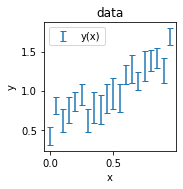

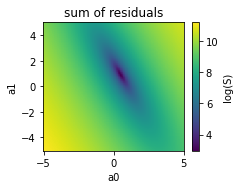

a0=0.6
a1=1.0


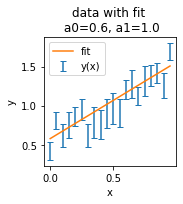

In [221]:
cm = 1/2.54

# helper function for 2D plot. You don't need to do anything here. This function moves an array by half a space so the 2D plot function further down in the notebook is correctly aligned with the array endpoints. 
def remesh(array):
    dx = array[1]-array[0]
    array = array-dx # shift by one unit to the left
    return np.hstack((array, array[-1]+dx)) # add one element on the right and return

# fit a model: y = a0 + a1x by trial and error, minimizing Residual
def linear_fit_by_trying_out_parameters(xs, ys, sigmas, a0_tries, a1_tries):
    a0_try = a0_tries#np.linspace(0,2,201)
    a1_try = a1_tries#np.linspace(0,3,301)
    x, y, sig = xs, ys, sigmas
    # Plot Values surrounded by errors so we can see some stuff
    fig, ax = plt.subplots(1,1,figsize=(6*cm, 6*cm))
    ax.errorbar(x, y, yerr=sig, linestyle='', capsize=3, label='y(x)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('data')
    #ax.set_xlim([0,1])
    #ax.set_ylim([0,2])
    ax.legend(loc='upper left')
    plt.show()
    ###
    # Compute Residuals
    S = np.zeros((len(a1_try), len(a0_try)))
    for i, a1_i in enumerate(a1_try):
        for j, a0_j in enumerate(a0_try):
            S[i,j] = np.sum(1/sig**2 * (y - (a0_j + a1_i*x))**2)
    ###
    # now plot log(S)
    fig, ax = plt.subplots(1,1, figsize=(8*cm, 6*cm))
    # shape into a meshgrid for 2D plot
    a0_grid, a1_grid = np.meshgrid(remesh(a0_try), remesh(a1_try))
    # plot log(S)
    c = ax.pcolor(a0_grid, a1_grid, np.log(S))
    # cosmetics
    fig.colorbar(c, ax=ax, label='log(S)')
    ax.set_xlabel('a0')
    ax.set_ylabel('a1')
    ax.set_title('sum of residuals')
    plt.show()
    ### MINIMUMS
    # by looking for the index with the minimum value of S, we can find the optimum for a0 and a1
    min_index_S = np.argmin(S) # this function returns the index of the flattened S array with the minimum value of S
    # now we recover the correct a0 and a1 fit values
    a0_index = min_index_S % len(a0_try)
    a1_index = min_index_S // len(a0_try)
    a0_fit = a0_try[a0_index]
    a1_fit = a1_try[a1_index]
    # ==============
    print(f'a0={a0_fit:.1f}')
    print(f'a1={a1_fit:.1f}')
    # finally, we plot the data with the acquired fit values 
    fig, ax = plt.subplots(1,1,figsize=(6*cm, 6*cm))
    ax.errorbar(x, y, yerr=sig, linestyle='', capsize=3, label='y(x)')
    ax.plot(x, a0_fit + a1_fit*x, label='fit')
    ax.set_title('data with fit \n a0=%.1f, a1=%.1f' % (a0_fit, a1_fit))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #ax.set_xlim([0,1])
    #ax.set_ylim([0,2])
    ax.legend(loc='upper left')
    plt.show()
    return a0_fit, a1_fit

def example_generate_data_and_linear_fit_by_trying_out_parameters():
    x = np.linspace(0,1,20, endpoint=False) # x values
    y = x + np.random.normal(loc=0, scale=0.1, size=len(x)) + 0.5 # y values with some gaussian randomness (mu=0, sigma=0.1) and offset of 0.5
    sig = 0.1 + np.random.random(len(x))*0.1 # sigma values
    a0_tries = np.linspace(-5, 5, 200)
    a1_tries = np.linspace(-5, 5, 200)
    linear_fit_by_trying_out_parameters(x,y,sig,a0_tries,a1_tries)
example_generate_data_and_linear_fit_by_trying_out_parameters()


##### Linear fit by calculating analytical solution
Wie Ex. 8 Aufg 2

solution vector:
[[0.51227595]
 [1.02806279]]
Covarianz Matrix:
[[ 0.00374419 -0.00574309]
 [-0.00574309  0.01238684]]


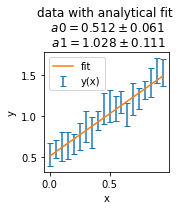

a0 =  0.51
a1 =  1.03
a0_err =  0.06
a1_err =  0.11


In [151]:
# fit a0 + a1*x = y, with analytical method
def linear_fit_analytical(xs, ys, sigmas):
    x=xs
    y=ys
    sig = sigmas
    w = 1/sig**2
    # normalmatrix 2x2
    N = np.zeros((2,2))
    N[0,0] = np.sum(w)
    N[0,1] = np.sum(w * x)
    N[1,0] = np.sum(w * x)
    N[1,1] = np.sum(w * x**2)
    # solution vector
    Y = np.zeros((2,1))
    Y[0] = np.sum(w * y)
    Y[1] = np.sum(w * x * y)
    # mit der Lösung
    a = np.linalg.inv(N)@Y
    # A@B is a shorthand for np.dot(A,B) and retuns the matrix product, while A*B attempts elementwise multiplication
    print("solution vector:")
    print(a)
    # und der Covarianz-Matrix
    C = np.linalg.inv(N)
    print("Covarianz Matrix:")
    print(C)
    a0_error = np.sqrt(C[0,0])
    a1_error = np.sqrt(C[1,1])
    fig, ax = plt.subplots(1,1,figsize=(6*cm, 7*cm))
    ax.errorbar(x, y, yerr=sig, linestyle='', capsize=3, label='y(x)')
    ax.plot(x, a[0,0] + a[1,0]*x, label='fit')
    ax.set_title('data with analytical fit \n $a0=%.3f \pm %.3f$ \n $a1=%.3f \pm %.3f$' % (a[0], a0_error, a[1], a1_error ))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #ax.set_xlim([0,1])
    #ax.set_ylim([0,2])
    ax.legend(loc='upper left')
    fig.tight_layout(pad=0.1)
    plt.show()
    print('a0 = ', '%.5f' % a[0])
    print('a1 = ', '%.5f' % a[1])
    print('a0_err = ', '%.5f' % a0_error)
    print('a1_err = ', '%.5f' % a1_error)

def example_generate_data_and_linear_fit_analytical():
    x = np.linspace(0,1,20, endpoint=False) # x values
    y = x + np.random.normal(loc=0, scale=0.1, size=len(x)) + 0.5 # y values with some gaussian randomness (mu=0, sigma=0.1) and offset of 0.5
    sig = 0.1 + np.random.random(len(x))*0.1 # sigma values
    linear_fit_analytical(x,y,sig)
#example_generate_data_and_linear_fit_analytical()

##### Polynomial fit by calculating analytical solution

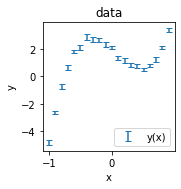

solution vector:
[[ 1.99021893]
 [-4.04237426]
 [-1.97282609]
 [ 9.05343547]]
Covarianz Matrix:
[[ 2.25600629e-03 -2.86339355e-04 -3.86820132e-03 -2.07528899e-05]
 [-2.86339355e-04  1.79041199e-02 -1.45506663e-03 -2.57759046e-02]
 [-3.86820132e-03 -1.45506663e-03  1.17374759e-02  3.47184071e-03]
 [-2.07528899e-05 -2.57759046e-02  3.47184071e-03  4.41827767e-02]]
Errors:
[0.04749743 0.13380628 0.10833963 0.210197  ]
a 0  =  [1.99021893]
a 0 _err =  0.047497434547172326
a 1  =  [-4.04237426]
a 1 _err =  0.133806277674048
a 2  =  [-1.97282609]
a 2 _err =  0.10833963230644506
a 3  =  [9.05343547]
a 3 _err =  0.21019699504611952


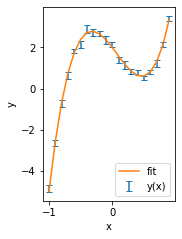

In [179]:
def polynomial_fit_analytical(xs, ys, sigmas, polyOrder=3):
    x = xs
    y = ys
    sig = sigmas
    n = polyOrder + 1
    N = np.zeros((n, n))
    Y = np.zeros((n,1))
    w = 1/sig**2
    for row in range(n):
        Y[row] = np.sum(w * x**row * y)
        for column in range(n):
            N[row, column] = np.sum(w * x**(row + column))
    # mit der Lösung
    a = np.linalg.inv(N)@Y 
    print("solution vector:")
    print(a)
    # und der Covarianz-Matrix
    C = np.linalg.inv(N)
    print("Covarianz Matrix:")
    print(C)
    a_errors = np.zeros(n)
    for i in range(0, n):
        a_errors[i] = np.sqrt(C[i,i])
    print("Errors:")
    print(a_errors)
    fig, ax = plt.subplots(1,1,figsize=(6*cm, 8*cm))
    ax.errorbar(x, y, yerr=sig, linestyle='', capsize=3, label='y(x)')
    polynom = np.zeros(len(x)) + a[0,0]
    for i in range(1, n):
        polynom += a[i,0]*x**i
    ax.plot(x, polynom, label='fit')
    #ax.set_title(polyOrder, 'th order data with analytical fit \n $a0=%.1f \pm %.2f$ \n $a1=%.1f \pm %.2f$ \n $a2=%.1f \pm %.2f$ \n $a3=%.1f \pm %.2f$' % (a[0], a_errors[0], a[1], a_errors[1], a[2], a_errors[2], a[3], a_errors[3]))
    for i in range(0, n):
        print('a',i, ' = ', a[i])
        print('a',i, '_err = ', a_errors[i])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #ax.set_xlim([-1,1])
    #ax.set_ylim([-4,4])
    ax.legend(loc='lower right')
    fig.tight_layout(pad=0.1)
    plt.show()

def example_polynomial_fit_third_order_analytical():
    # create data
    np.random.seed(1) # so we always get the same random data
    x = np.linspace(-1,1,20, endpoint=False) # x values
    a0, a1, a2, a3 = 2.0, -4.0, -2.0, 9.0
    #======================= write here
    y = a0 + a1*x + a2*x**2 + a3*x**3 + np.random.normal(loc=0, scale=0.1, size=len(x)) # y values with some gaussian randomness (mu=0, sigma=0.3) and offset of 0.5
    #=======================
    sig =  0.1 + np.random.random(len(x))*0.1 # sigma values
    fig, ax = plt.subplots(1,1,figsize=(6*cm, 6*cm))
    ax.errorbar(x, y, yerr=sig, linestyle='', capsize=3, label='y(x)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('data')
    ax.legend(loc='lower right')
    plt.show()
    polynomial_fit_analytical(x, y, sig, polyOrder=3)
example_polynomial_fit_third_order_analytical()


##### Non linear fit by trying out parameters
Ex. 9 Aufg. 1

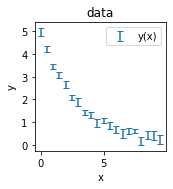

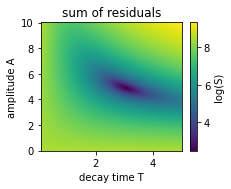

decay Time T = 3.06450
amplitude A = 4.90000


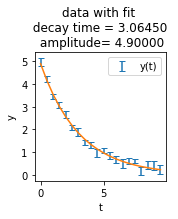

In [168]:
def exp_decay(t, decay_time, amplitude):
    return amplitude * np.exp(-t/decay_time)

# Copy this stuff and adjust it to your specific function
# this example fits to  y(t) = A*exp(t/T)
def non_linear_fit_by_trying_out_parameters(t,y,sig, T_tries, A_tries):
    w = 1/sig**2
    # Residuals for A_tries x T_tries
    S = np.zeros((len(A_tries), len(T_tries)))
    for i, amp_i in enumerate(A_tries):
        for j, dt_j in enumerate(T_tries):
            S[i,j] = np.sum(1/sig**2 * (y - exp_decay(t, dt_j, amp_i))**2) # ADJUST THIS LINE FOR YOUR FUNCTION
    # Plot log(S) for minimum visualization
    fig, ax = plt.subplots(1,1, figsize=(8*cm, 6*cm))
    c = ax.pcolormesh(T_tries, A_tries, np.log(S), shading='nearest')
    fig.colorbar(c, ax=ax, label='log(S)')
    ax.set_xlabel('decay time T')
    ax.set_ylabel('amplitude A')
    ax.set_title('sum of residuals')
    plt.show()
    # Find the minimum A and T inside S
    min_index_S = np.argmin(S) # this function returns the index of the flattened S array with the minimum value of S
    T_index = min_index_S % len(T_tries)
    A_index = min_index_S // len(T_tries)
    T_fit = T_tries[T_index] # T fit
    A_fit = A_tries[A_index] # A fit
    print(f'decay Time T = {T_fit:.5f}')
    print(f'amplitude A = {A_fit:.5f}')

    # finally, we plot the data with the acquired fit values
    fig, ax = plt.subplots(1,1,figsize=(6*cm,6*cm))
    ax.errorbar(t, y, yerr=sig, linestyle='', capsize=3, label='y(t)')
    ax.plot(t, exp_decay(t, T_fit, A_fit))
    ax.set_title('data with fit \n decay time = %.5f \n amplitude= %.5f' % (T_fit, A_fit))
    ax.set_xlabel('t')
    ax.set_ylabel('y')
    ax.legend(loc='upper right')
    plt.show()

def example_non_linear_fit_by_trying_out_parameters():
    param_T = 3
    param_A = 5
    t = np.linspace(0, 10, 20, endpoint=False)
    y = exp_decay(t, param_T, param_A) + np.random.normal(loc=0, scale=0.1, size=len(t))
    sig = 0.1 + np.random.random(len(t))*0.1
    fig, ax = plt.subplots(1,1,figsize=(6*cm, 6*cm))
    ax.errorbar(t, y, yerr=sig, linestyle='', capsize=3, label='y(x)')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('data')
    ax.legend(loc='upper right')
    plt.show()

    T_tries = np.linspace(0.1, 5, 201)
    A_tries = np.linspace(0, 10, 301)
    non_linear_fit_by_trying_out_parameters(t, y, sig, T_tries=T_tries, A_tries=A_tries)
example_non_linear_fit_by_trying_out_parameters()



##### Non-linear fit using gradient descent [SIMPLE (WEAK) VERSION]
In this exercise we optimize the blind parameter search from Aufg. 1 using gradient descent. The idea is that instead of searching the whole parameter space, we only search along the direction of decreasing S. That should eventually bring us close to the minimum. 

Fit Results:
Best fit:  [3.11452997 2.03583238]
Iterations:  25796
final da:  0.0009998670206959853
Covariance Matrix: 
[[ 0.04847485 -0.01222171]
 [-0.01222171  0.00723501]]
a errors:
[0.22017004 0.08505884]


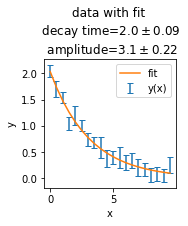

In [203]:
# Sum of residuals for any function f(x) with data y(x) and weights w(x)
def Sres(x, y, w, func, a):
    return np.sum(w*(y-func(x,a))**2)

# Function to compute the Gradient (with dS[i]=dS/da[i])
# Numerical calculation of the first derivative of S
def dS(S, x, y, w, model, a, delta):
    # Number of fit parameters
    m = len(a)

    delta_S = np.zeros(m)
    # iterate over all parameters
    for i in range(0, m):
        # Differential vector for only the differentiation parameter (partial differentiation)
        delta_a = np.zeros(m)
        delta_a[i] = delta
        # Differential vector at the position a
        delta_a_plus = a + delta_a
        delta_a_minus = a - delta_a
        # Calculate partial differential for i-th parameter 
        delta_S[i] = (S(x, y, w, model, delta_a_plus)-S(x, y, w, model, delta_a_minus))/(2*delta)
    return delta_S

# Numerical calculation of the second derivative of S
def dS2(S, x, y, w, model, a, delta):
    # Number of fit parameters
    m = len(a)
    # Return vector 
    delta_S = np.zeros((m,m))
    # Iterate over all parameters
    for i in range(0,m):
        for j in range(0,m):
            # Differential vector for only the differentiation parameter (partial differentiation)
            delta_ai = np.zeros(m)
            delta_aj = np.zeros(m)
            delta_ai[i] = delta
            delta_aj[j] = delta
                       
            # Differential vector at the position a
            delta_a_plusplus = a + delta_ai + delta_aj
            delta_a_plusminus = a + delta_ai - delta_aj
            delta_a_minusplus = a - delta_ai + delta_aj
            delta_a_minusminus = a - delta_ai - delta_aj
            
            # Calculate partial differential for i-th parameter 
            delta_S[i,j] = (S(x, y, w, model, delta_a_plusplus)-S(x, y, w, model, delta_a_minusplus)-S(x, y, w, model, delta_a_plusminus)+S(x, y, w, model, delta_a_minusminus))/(2*delta)**2
    return delta_S

# Gradient descent without adaptive step size
# model: this selects the function we fit to
# min gradient: the convergence criterion. When the gradient gets under this value, the loops stops
# max_i: max number of iterations
# aplha: this parameter determins how fast we adapt the parameters in the search. In each step we change the guess for our fit parameters by alpha x gradient. 
# delta: this is the range over which we determine the gradient (the slope) of S with respect to a parameter a. We compute (S(a + delta) - S(a - delta))/(2*delta) to approximate the partial derivative of S with respect to a.  
def gradient_descent_simple(S, x, y, w, model, a_init, min_gradient, max_i, alpha, delta):
    # Gradient descent fitting
    # First step
    # ----------
    # Next Values of parameters
    a_next = a_init
    # Calculate gradient for given value of parameters
    gradient =  dS(S, x, y, w, model, a_next, delta)
    # Magnitude of the gradient
    d_a = [np.linalg.norm(gradient)]
    # Start iteration
    # ---------------
    i = 0
    while ((d_a[i]>min_gradient) and (i<max_i)):
        # Calculate next step using the gradient 
        a_next = a_next - alpha * gradient
        # Calculate next gradient and Hesse matrix
        gradient =  dS(S, x, y, w, model, a_next, delta)
        # Termination condition
        d_a = np.append(d_a, np.linalg.norm(gradient))
        # Next Step
        i = i+1
    # =========== compute covariance matrix
    hesse = dS2(S, x, y, w, model, a_next, delta)
    cov_matrix = 2*np.linalg.inv(hesse)
    # ===========
    return a_next, i, d_a, cov_matrix

def gradient_descent_simple_with_plot(t, y, sig, model, a_init):
    w = 1/sig**2

    model = model
    min_gradient = 0.001
    max_i = 30000
    alpha = 1e-5
    delta = 1e-3
    a_init = a_init#np.array([1,1])
    a_fit, iterations, d_a, cov_matrix = gradient_descent_simple(Sres, t, y, w, model, a_init, min_gradient, max_i, alpha, delta)
    print('Fit Results:')
    print('============')
    print('Best fit: ', a_fit)
    print('Iterations: ', iterations)
    print('final da: ', d_a[-1])
    print('============')
    print('Covariance Matrix: ')
    print(cov_matrix)

    a_errors = np.zeros(len(a_fit))
    for i in range(0, len(a_fit)):
        a_errors[i] = np.sqrt(cov_matrix[i,i])
    print('a errors:')
    print(a_errors)

    # finally, we plot the data with the acquired fit values 
    fig, ax = plt.subplots(1,1,figsize=(6*cm, 6*cm))
    ax.errorbar(t, y, yerr=sig, linestyle='', capsize=3, label='y(x)')
    ax.plot(t, exp_decay(t, *a_fit), label='fit')
    # add the errors of the fit parameters to the title of the plot
    # ax.set_title('data with fit \n decay time = %.1f \n amplitude= %.1f' % (a_fit[1], a_fit[0])) # <--
    ax.set_title('data with fit \n decay time=$%.1f \pm %.2f$ \n amplitude=$%.1f \pm %.2f$' % (a_fit[1], a_errors[1], a_fit[0], a_errors[0]))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='upper right')
    plt.show()


def example_gradient_descent_simple():
    # Example model
    def exp_decay_model(x, a):
        return a[1]*np.exp(-x/a[0])

    t = np.linspace(0,10,20, endpoint=False) # x values
    y = exp_decay_model(t, [3, 2]) + np.random.normal(loc=0, scale=0.1, size=len(t))
    sig = 0.1 + np.random.random(len(t))*0.1 # sigma values

    gradient_descent_simple_with_plot(t,y,sig,model=exp_decay_model,a_init=np.array([2,1]))

example_gradient_descent_simple()


##### Non-linear fit using gradient descent [Adaptive Step Size Version]

Fit Results:
Best fit:  [3.15369424 1.88057277]
Iterations:  3312
final da:  0.0009972710906925209
Covariance Matrix: 
[[ 0.07130392 -0.01933848]
 [-0.01933848  0.01110313]]
a errors:
[0.26702794 0.10537141]


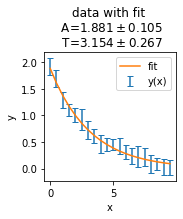

Fit Results:
Best fit:  [-0.08364907  5.18225756]
Iterations:  1401
final da:  0.0009980971459430546
Covariance Matrix: 
[[ 0.02315624 -0.00113982]
 [-0.00113982  0.01640396]]
a errors:
[0.15217175 0.12807793]


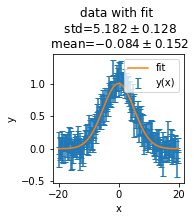

In [212]:
def gradient_descent_adaptive(S, x, y, w, model, a_init, min_gradient, max_i, alpha, delta):
    # Gradient descent fitting
    # First step
    # ----------
    # Next Values of parameters
    a_next = a_init
    # Calculate gradient and Hesse matrix for given value of parameters
    gradient =  dS(S, x, y, w, model, a_next, delta)
    hesse = dS2(S, x, y, w, model, a_next, delta)
    hdiag = np.diagonal(hesse)
    # Magnitude of the gradient
    d_a = [np.linalg.norm(gradient)]
    # Start iteration
    # ---------------
    i = 0
    while ((d_a[i]>min_gradient) and (i<max_i)):
        # Calculate next step using the gradient 
        # ============= scale alpha with the inverse of the second derivative
        a_next = a_next - alpha * 1/(hdiag+0.0001) * gradient
        # =============
        # Calculate next gradient and Hesse matrix
        gradient =  dS(S, x, y, w, model, a_next, delta)
        hesse = dS2(S, x, y, w, model, a_next, delta)
        hdiag = np.diagonal(hesse)
        # Termination condition
        d_a = np.append(d_a, np.linalg.norm(gradient))
        # Next Step
        i = i+1
    # =========== compute covariance matrix
    cov_matrix = 2*np.linalg.inv(hesse)
    # ===========
    return a_next, i, d_a, cov_matrix

def gradient_descent_adaptive_with_plot(t, y, sig, model, a_init, alpha=1e-2, delta=1e-3, a_labels=['decay_time', 'amplitude']):
    w = 1/sig**2

    model = model
    min_gradient = 0.001
    max_i = 12000
    alpha = alpha#1e-2
    delta = delta#1e-3
    a_init = a_init#np.array([1,1])
    a_fit, iterations, d_a, cov_matrix = gradient_descent_adaptive(Sres, t, y, w, model, a_init, min_gradient, max_i, alpha, delta)
    print('Fit Results:')
    print('============')
    print('Best fit: ', a_fit)
    print('Iterations: ', iterations)
    print('final da: ', d_a[-1])
    print('============')
    print('Covariance Matrix: ')
    print(cov_matrix)

    a_errors = np.zeros(len(a_fit))
    for i in range(0, len(a_fit)):
        a_errors[i] = np.sqrt(cov_matrix[i,i])
    print('a errors:')
    print(a_errors)

    # finally, we plot the data with the acquired fit values 
    fig, ax = plt.subplots(1,1,figsize=(6*cm, 6*cm))
    ax.errorbar(t, y, yerr=sig, linestyle='', capsize=3, label='y(x)')
    ax.plot(t, model(t, a_fit), label='fit')
    # add the errors of the fit parameters to the title of the plot
    # ax.set_title('data with fit \n decay time = %.1f \n amplitude= %.1f' % (a_fit[1], a_fit[0])) # <--
    ax.set_title('data with fit \n %s=$%.3f \pm %.3f$ \n %s=$%.3f \pm %.3f$' % (a_labels[1], a_fit[1], a_errors[1], a_labels[0], a_fit[0], a_errors[0]))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='upper right')
    plt.show()

def example_gradient_descent_adaptive_decay_model():
    # Example model
    def exp_decay_model(x, a):
        return a[1]*np.exp(-x/a[0])
    t = np.linspace(0,10,20, endpoint=False) # x values
    y = exp_decay_model(t, [3, 2]) + np.random.normal(loc=0, scale=0.1, size=len(t))
    sig = 0.1 + np.random.random(len(t))*0.1 # sigma values
    gradient_descent_adaptive_with_plot(
        t,y,sig,
        model=exp_decay_model,
        a_init=np.array([1,1]),
        a_labels=['T', 'A'])
example_gradient_descent_adaptive_decay_model()

def example_gradient_descent_adaptive_gaussian_model():
    def gaussian_model(x, a):
        x0 = a[0]
        std = a[1]
        return np.exp(-1/2 * ((x-x0)/std)**2)
    x = np.linspace(-20,20,200,endpoint=False)
    x0 = 0
    std = 5
    y = gaussian_model(x, np.array([x0, std])) + np.random.normal(loc=0, scale=0.1, size=len(x))
    sig = 0.1 + np.random.random(len(x))*0.1
    gradient_descent_adaptive_with_plot(
        x,y,sig,
        model=gaussian_model,
        a_init=[1,1],
        alpha=0.01,
        delta=0.0001,
        a_labels=['mean', 'std'])
example_gradient_descent_adaptive_gaussian_model()
    

In [ ]:
##### Fitting using lmfit

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 200
    # variables        = 3
    chi-square         = 5935.37412
    reduced chi-square = 30.1288027
    Akaike info crit   = 684.073595
    Bayesian info crit = 693.968547
[[Variables]]
    amplitude:  13.2262787 +/- 0.25999789 (1.97%) (init = -0.5)
    center:     0.04745275 +/- 0.12007036 (253.03%) (init = 0.4215385)
    sigma:      5.21747153 +/- 0.11458748 (2.20%) (init = 7.4)
    fwhm:       12.2862063 +/- 0.26983290 (2.20%) == '2.3548200*sigma'
    height:     1.01131784 +/- 0.01922219 (1.90%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.588
    C(amplitude, center) = -0.179
    C(center, sigma)     = -0.132


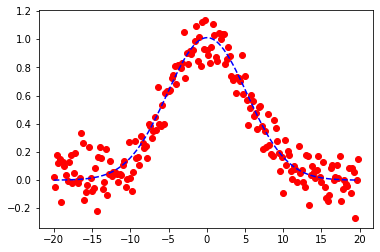

In [7]:
import numpy as np
from lmfit import Model
from lmfit.models import GaussianModel, ConstantModel
import matplotlib.pyplot as plt

def lmfit_fitting_gaussian(x, y, sig):
    def gaussian_model(x, a):
        x0, std = a[0], a[1]
        return np.exp(-1/2 * ((x-x0)/std)**2)
    w = 1/sig**2 # Or: 1/sig**2
    model = GaussianModel()
    pars = model.guess(y, x=x, amplitude=-0.5)
    result = model.fit(y, pars, x=x, weights=w)
    print(result.fit_report())
    plt.plot(x, y, 'ro', ms=6)
    plt.plot(x, result.best_fit, 'b--')
    
def example_lmfit_fitting_gaussian():
    def gaussian_model(x, a):
        x0 = a[0]
        std = a[1]
        return np.exp(-1/2 * ((x-x0)/std)**2)
    x = np.linspace(-20,20,200, endpoint=False) # x values
    x0 = 0
    std = 5
    y = gaussian_model(x, [x0, std]) + np.random.normal(loc=0, scale=0.1, size=len(x))  
    sig = 0.1 + np.random.random(len(x))*0.1 # sigma values
    lmfit_fitting_gaussian(x, y, sig)
example_lmfit_fitting_gaussian()

##### Polynomial Fit Polynom Fit mit Numpy

[ 2.39960908  1.78313191 20.37888229] 
 [[ 5.76210853e-05 -8.66510237e-22 -7.83646760e-05]
 [-8.66510237e-22  6.26733020e-05 -9.51676677e-22]
 [-7.83646760e-05 -9.51676677e-22  1.91811650e-04]]


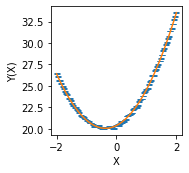

In [35]:
import numpy as np
from matplotlib import pyplot as plt

def example_model(x, a):
    return a[2] + a[1]*x + a[0]*x**2

x = np.linspace(-2, 2, 101)
y = example_model(x, [2.4, 1.8, 20.4]) + 0.1*np.array([np.random.normal() for i in range(0,101)])
w = np.ones(101)*0.05

# Polifit
degree_ = 2
a, cov = np.polyfit(x, y, degree_, w = w, cov = True)

print(a, "\n",cov)

cm = 1/2.54
fig, ax = plt.subplots(1,1,figsize=(6*cm, 6*cm))
ax.errorbar(x, y, yerr=w, linestyle='', capsize=3, label='y(x)')
ax.plot(x, example_model(x, a), label='fit')
ax.set_xlabel('X')
ax.set_ylabel('Y(X)')
plt.show()

##### Exp Fit Exponential Fit Numpy

Coefficients (a's):
[4.06944544 0.49840469]
Covariance Matrix:
[[ 5.13492746e-05 -1.27543441e-06]
 [-1.27543441e-06  3.18254636e-08]]


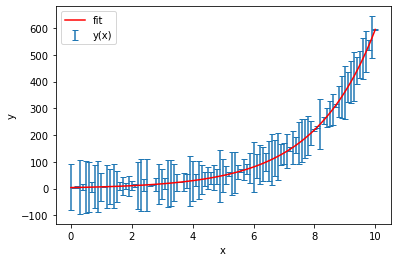

In [41]:
from scipy.optimize import curve_fit

x = np.linspace(0,10,101)
y = 4*np.exp(0.5*x) + np.random.random(101)
y_err = 100*np.random.random(101)

def example_model_exp(x, a0, a1):
    return a0*np.exp(a1*x)

a, cov = curve_fit(example_model_exp, x, y, sigma = y_err)

print("Coefficients (a's):")
print(a)
print("Covariance Matrix:")
print(cov)

fig, ax = plt.subplots(1,1)
ax.errorbar(x, y, yerr=y_err, linestyle='', capsize=3, label='y(x)')
ax.plot(x, example_model_exp(x, a[0], a[1]), label='fit', color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='upper left')
plt.show()

##### Andere Funktionen fitten mit scipy.optimize.curve_fit

Coefficients (a's):
[3. 2. 1.]
Covariance Matrix:
[[ 1.37787073e-32 -1.62110252e-33 -5.43028783e-33]
 [-1.62110252e-33  5.92156827e-34  1.33693439e-33]
 [-5.43028783e-33  1.33693439e-33  3.61399444e-33]]


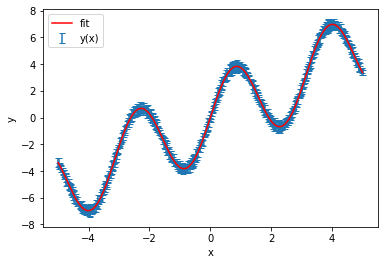

In [84]:
from scipy.optimize import curve_fit

def example_model_3(x, a0, a1, a2):
    return a0*np.sin(a1*x) + a2*x

x = np.linspace(-5,5,600)
y = example_model_3(x, 3, 2, 1)
y_err = 0.5*np.random.random(600)

a, cov = curve_fit(example_model_3, x, y, sigma = y_err)

print("Coefficients (a's):")
print(a)
print("Covariance Matrix:")
print(cov)

fig, ax = plt.subplots(1,1)
ax.errorbar(x, y, yerr=y_err, linestyle='', capsize=3, label='y(x)')
ax.plot(x, example_model_3(x, a[0], a[1], a[2]), label='fit', color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='upper left')
plt.show()